# Лабораторная работа №4
## Выполнил Буканов Никита ПМ-21М
## Вариант 2

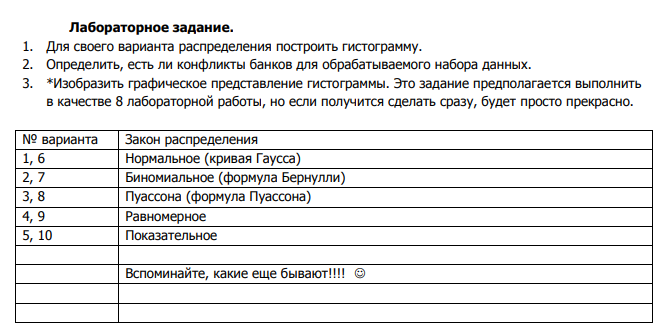

Часть написанная мной. 
```c++
void randomInit (uint *a, size_t n, uint * h )
{
  std::random_device rd;
  std::mt19937 gen(rd());
  std::binomial_distribution<uint> d(255, 0.6);
  for (size_t i = 0; i < n; i++ )
  {
    uchar b1, b2, b3, b4;
    b1 = d(gen) & 0xFFu;
    b2 = d(gen) & 0xFFu;
    b3 = d(gen) & 0xFFu;
    b4 = d(gen) & 0xFFu;
    a[i] = b1 | (b2 << 8u) | (b3 << 16u) | (b4 << 24u);
    h[b1]++;
    h[b2]++;
    h[b3]++;
    h[b4]++;
  }
}
```

```c++
#include <cassert>
#include <cstdio>
#include <random>

typedef unsigned int uint;
typedef unsigned char uchar;
constexpr size_t N = (6*1024*1024); // Размер массива.
constexpr size_t LOG2_WARP_SIZE = 5; // Логарифм размера warp'a по основанию 2
constexpr size_t WARP_SIZE = 32; // Размер warp'a
constexpr size_t TAG_MASK = 0x07FFFFFFU; // Маска для снятия идентификатора нити.
constexpr size_t NUM_BINS = 256; // Число счетчиков в гистограмме.
constexpr size_t NUM_WARPS = 6; // Число warp'ов в блоке.


inline __device__ void addByte (volatile uint * warpHist, uint data, uint threadTag) {
  uint count;
  do
  {
    // Прочесть текущее значение счетчика и снять иденификатор нити.
    count = warpHist [data] & TAG_MASK;
    // Увеличить его на единицу и поставить свой идентификатор.
    count = threadTag | (count + 1);
    // Осуществить запись.
    warpHist [data] = count;
  }
  while ( warpHist [data] != count ); // Проверить, прошла ли запись этой нитью.
}

inline __device__ void addWord (volatile uint * warpHist, uint data, uint tag )
{
  addByte(warpHist, (data >> 0u) & 0xFFU, tag) ;
  addByte(warpHist, (data >> 8u ) & 0xFFU, tag) ;
  addByte(warpHist, (data >> 16u) & 0xFFU, tag) ;
  addByte(warpHist, (data >> 24u) & 0xFFU, tag) ;
}

__global__ void histogramKernel (uint * partialHistograms, const uint * data, uint dataCount ) {
  // Своя гистограмма на каждый warp.
  __shared__ uint hist [NUM_BINS * NUM_WARPS];
  uint *warpHist = hist + (threadIdx.x >> LOG2_WARP_SIZE) * NUM_BINS;
  // Очистить счетчики гистограмм.
  #pragma unroll
  for ( uint i = 0; i < NUM_BINS / WARP_SIZE; i++ )
    hist [threadIdx.x + i *NUM_WARPS *WARP_SIZE] = 0;
  // Получить id для данной нити.
  uint tag = threadIdx.x << (32 - LOG2_WARP_SIZE);
  __syncthreads();
  // Построить гистограммы по заданному набору элементов.
  for ( uint pos = blockIdx.x * blockDim.x + threadIdx.x; pos < dataCount;
        pos += blockDim.x * gridDim.x ) {
    uint d = data [pos];
    addWord ( warpHist, d, tag );
  }
  __syncthreads();
  // Объединить гистограммы данного блока
  // и записать результат в глобальную память.
  // 192 нити суммируют данные
  // по 256 элементам гистограммы.
  for ( uint bin = threadIdx.x; bin < NUM_BINS; bin += NUM_WARPS * WARP_SIZE )
  {
    uint sum = 0;
    for ( uint i = 0; i < NUM_WARPS; i++ )
      sum += hist [bin + i * NUM_BINS] & TAG_MASK;
    partialHistograms [blockIdx.x * NUM_BINS + bin] = sum;
  }
}


//
// Объединить гистограммы, один блок на каждый из NUM_BINS элементов.
//
__global__ void mergeHistogramKernel(uint * outHistogram,
                                     const uint * partialHistograms,
                                     uint histogramCount ) {
  uint sum = 0;
  for ( uint i = threadIdx.x; i < histogramCount; i += 256 )
    sum += partialHistograms [blockIdx.x + i * NUM_BINS];
  __shared__ uint data [NUM_BINS];
  data [threadIdx.x] = sum;
  for ( uint stride = NUM_BINS / 2; stride > 0; stride /= 2) {
    __syncthreads();
    if ( threadIdx.x < stride ) data [threadIdx.x] += data [threadIdx.x + stride];
  }
  if ( threadIdx.x == 0 ) outHistogram [blockIdx.x] = data [0];
}


void histogram (uint * histogram, void * dataDev, uint byteCount ) {
  assert( byteCount % 4 == 0 );
  size_t n = byteCount / 4;
  size_t numPartials = 240;
  uint * partialHistograms = nullptr;

  // Выделить память под гистограммы блоков.
  cudaMalloc ( (void **) &partialHistograms, numPartials * NUM_BINS * sizeof ( uint ) );

  // Построить гистограммы для каждого блока.
  histogramKernel<<<dim3( numPartials ), dim3(NUM_WARPS * WARP_SIZE)>>>(partialHistograms, (uint *) dataDev, n);
  // Объединить гистограммы отдельных блоков вместе.

  mergeHistogramKernel<<<dim3(NUM_BINS),
                         dim3(256)>>>(histogram, partialHistograms, numPartials);
  // Освободить выделенную память.
  cudaFree (partialHistograms);
  // Заполнить массив случайными байтами
}


int main()
{
  uint* a = new uint [N];
  uint* hDev = nullptr;
  uint* aDev = nullptr;
  uint h[NUM_BINS];
  uint hHost[NUM_BINS];

  cudaEvent_t start, stop;
  float gpuTime = 0.0f;

  memset(hHost, 0, sizeof(hHost));
  randomInit(a, N, hHost);
  cudaEventCreate (&start);
  cudaEventCreate (&stop);
  cudaEventRecord ( start, nullptr);
  cudaMalloc((void **)&aDev, N * sizeof(uint));
  cudaMalloc((void **)&hDev, NUM_BINS * sizeof(uint));
  cudaMemcpy(aDev, a,N * sizeof(uint),cudaMemcpyHostToDevice);
  
  histogram(hDev, aDev, 4 * N);
  cudaMemcpy(h, hDev, NUM_BINS * sizeof (uint), cudaMemcpyDeviceToHost);
  
  cudaFree(aDev);
  cudaFree(hDev);

  cudaEventRecord(stop, nullptr);
  cudaEventSynchronize(stop);
  cudaEventElapsedTime(&gpuTime, start, stop );
  printf("Elapsed time: %.2f\n", gpuTime );
  for (int i = 0; i < NUM_BINS; i++ )
    if (h[i] != hHost [i])
      printf ("Diff at %d %d, %d\n", i, h [i], hHost[i] );
  delete [] a;
  return 0;
}
```

Как следует из текста лабораторной предлагаемый вариант программы не имеет конфликтов по банкам памяти.
Это же подтверждает cuda-memcheck.

In [4]:
! ../cmake-build-debug/lab4

Elapsed time: 9.09
